In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score

Nejprve jsme museli naimportovat všechny potřebné knihovny a nyní můžeme načíst dataset.

In [2]:
df = pd.read_csv('data_wisconsin.csv')
df.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Po zobrazení začátku dat a chybějících hodnot můžeme odstranit sloupec "Unnamed: 32" a rozdělit data na trénovací a testovací.

In [4]:
df = df.drop('Unnamed: 32', axis=1)
X = df.drop(['diagnosis', 'id'], axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Nyní se podíváme na silhouette score a rozhodnout, kolik clusterů se vyplatí udělat.

In [5]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_scores.append(silhouette_avg)

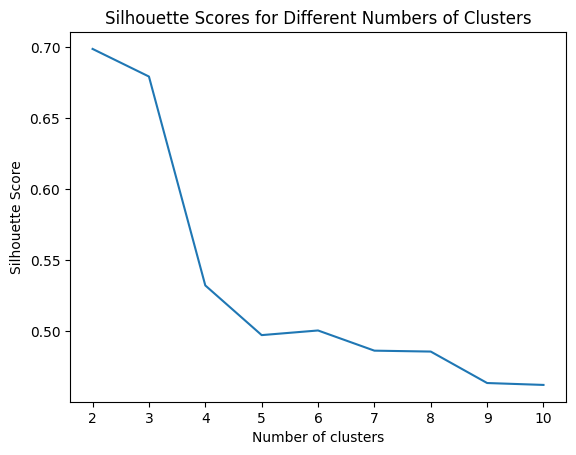

In [6]:
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Z grafu silhouette scores to vypadá, že nejlepší rozděllení je do dvou clusterů. Nyní můžeme tedy rozdělit trénovací data na dva clustery a podívat se na to, jak jsou clustery rozděleny.

In [7]:
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(X_train)

labels = kmeans.predict(X_train)

centroids = kmeans.cluster_centers_
X_train = pd.DataFrame(X_train)
X_train['cluster'] = labels

In [8]:
y_train_encoded = y_train.map({'B': 0, 'M': 1})
train_accuracy = accuracy_score(y_train_encoded, labels)
if train_accuracy < 0.5:
    train_accuracy = 1 - train_accuracy
train_accuracy

0.8492462311557789

Custery, do kterých jsou data rozděleny pomocí k-means jsou přesné z 85 %, co se týče určování diagnózy.

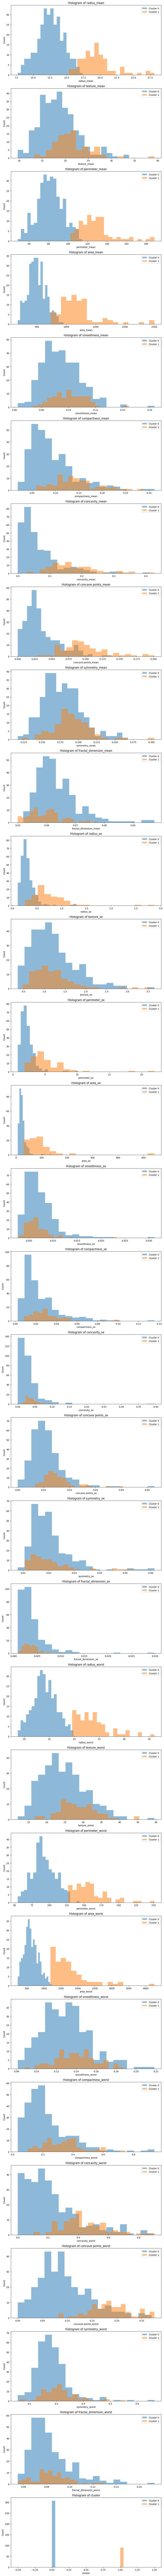

In [9]:
attributes = X_train.columns

num_attributes = len(attributes)
fig, axes = plt.subplots(num_attributes, 1, figsize=(10, 5 * num_attributes))

for i, attr in enumerate(attributes):
    cluster_0 = X_train[X_train['cluster'] == 0][attr]
    cluster_1 = X_train[X_train['cluster'] == 1][attr]

    axes[i].hist(cluster_0, bins=20, alpha=0.5, label='Cluster 0')
    axes[i].hist(cluster_1, bins=20, alpha=0.5, label='Cluster 1')
    axes[i].set_title(f'Histogram of {attr}')
    axes[i].set_xlabel(attr)
    axes[i].set_ylabel('Count')
    axes[i].legend()

plt.tight_layout()
plt.show()

Ne ze všech atributů je možné rozdělit data do dvou clusterů. Níže jsou uvedeny ty, ze kterých to poměrně dobře jde:
Pravidla pro cluster 1:

radius_mean >= 17.5

perimeter_mean >= 120

area_mean >= 1000

area_se >= 75

area_worst >= 1200

perimeter_worst >= 130

radius_worst >= 20

Nyní mvytvoříme funkci na klasifikaci pomocí nalezených pravidel.

In [10]:
def classify_to_cluster_1(data_point):
    if (data_point['radius_mean'] >= 17.5 or
        data_point['perimeter_mean'] >= 120 or
        data_point['area_mean'] >= 1000 or
        data_point['area_se'] >= 75 or
        data_point['area_worst'] >= 1200 or
        data_point['perimeter_worst'] >= 130 or
        data_point['radius_worst'] >= 20):
        return 1
    else:
        return 0

Pomocí této funkce můžeme nyní klasifikovat trénovací množinu a zjistit, jak doře pravidla vystihují rozdělení do clusterů. Budeme muset ještě zabudovat kontrolu, jestli náhodou nebyly clustery prohozeny a pravidla tedy fungují naprosto opačně.

In [11]:
results = X_train.apply(classify_to_cluster_1, axis=1)
results = results.astype(int)

In [12]:
results.sum()

94

In [13]:
accuracy = (results == labels).mean()
if accuracy < 0.5:
    accuracy = 1 - accuracy
accuracy

0.992462311557789

Vypadá to, že pravidla vystihují rozdělení do clusterů velmi dobře. Nyní můžeme zkusit, jak přesná bude klasifikace.

In [15]:
test_results = X_test.apply(classify_to_cluster_1, axis=1)
test_results = test_results.astype(int)
y_test_encoded = y_test.map({'B': 0, 'M': 1})
test_accuracy = accuracy_score(y_test_encoded, test_results)
if test_accuracy < 0.5:
    test_accuracy = 1 - test_accuracy
test_accuracy

0.8538011695906432

Na testovacích datech má klasifikace pomocí pravidel 85% úspěšnost, což je velmi dobrý výsledek, jelikož podobnou přesnost měl clustering i na trénovacích datech.